In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('ggplot')

# Homework 33

In [2]:
#constants
a = .34
b = -.045
mu = .08

In [3]:
def ADI(dt, n_x, n_y, n_t, u0, f, xlim=(-90,90), ylim=(-90,90)):
    #initialize
    dx = (xlim[1] - xlim[0])/n_x
    dy = (ylim[1] - ylim[0])/n_y
    U = [u0]
    
    #predictor step: P1 U* = U P2
    P1 = sp.diags([-dt/2/dx**2, 1 + dt/dx**2, -dt/2/dx**2],
                  [-1, 0, 1], shape=(n_x, n_x)).todense()
    P1[0, -1] = -dt/2/dx**2    #periodic
    P1[-1, 0] = -dt/2/dx**2
    P2 = sp.diags([dt/2/dy**2, 1 - dt/dy**2, dt/2/dy**2], [-1, 0, 1],
                  shape=(n_y, n_y)).todense()
    P2[0, -1] = dt/2/dy**2
    P2[-1, 0] = dt/2/dy**2

    #corrector step: U C1 = C2 U*
    C1 = sp.diags([-dt/2/dy**2, 1 + dt/dy**2, -dt/2/dy**2],
                  [-1, 0, 1], shape=(n_y, n_y)).todense()
    C1[0, -1] = -dt/2/dy**2
    C1[-1, 0] = -dt/2/dy**2
    C2 = sp.diags([dt/2/dx**2, 1 - dt/dx**2, dt/2/dx**2], [-1, 0, 1],
                  shape=(n_x, n_x)).todense()
    C2[0, -1] = dt/2/dx**2
    C2[-1, 0] = dt/2/dx**2
    
    #iterate
    t = 0
    while t <= n_t:
        u = U[-1].copy()
        u_half = np.linalg.solve(P1, (u @ P2) + dt/2*f(t, u))
        u = np.linalg.solve(C1.T, (C2 @ u_half + dt/2*f(t, u_half)).T).T
        U.append(u)
        t += 1
        
    return U

In [4]:
def periodic(dt, Nx, Ny, Nt, u0, v0):
    #solve U
    #     f_u = lambda t, u: (u * (1 - u) * (u - a)) / mu
    f_u = lambda t, u: 1/mu * np.multiply(np.multiply(u, 1 - u), u - a)
    U = ADI(dt, Nx, Ny, Nt, u0, f_u)
    
    #solve V
    f_v = lambda t, v: U[t] - v + b
    V = ADI(dt, Nx, Ny, Nt, v0, f_v)
    return V

In [5]:
#given
x_max, x_min = 90, -90
y_max, y_min = 90, -90

#constants
Nx = 360
Ny = 360
y_range = np.linspace(y_min, y_max, Ny+1)[:-1]    #periodic
x_range = np.linspace(x_min, x_max, Nx+1)[:-1]
X, Y = np.meshgrid(y_range, x_range)

#initial values
rand_prd = lambda x, y: np.sin(np.pi*x/90) * np.sin(np.pi*y/90)
u0 = rand_prd(X, Y)
v0 = u0.copy()

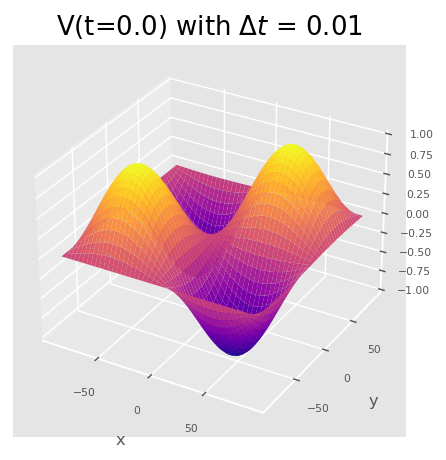

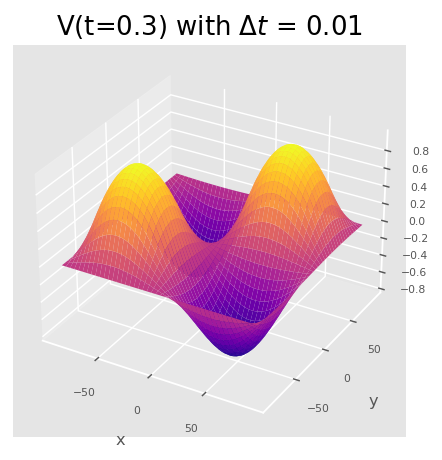

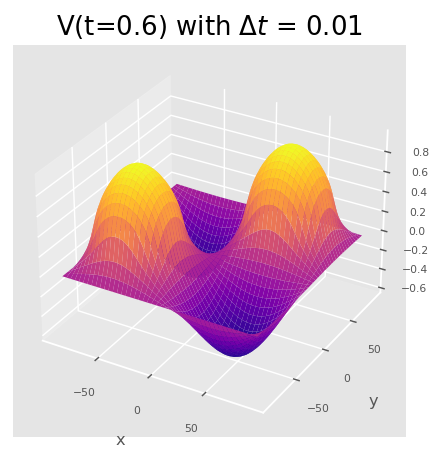

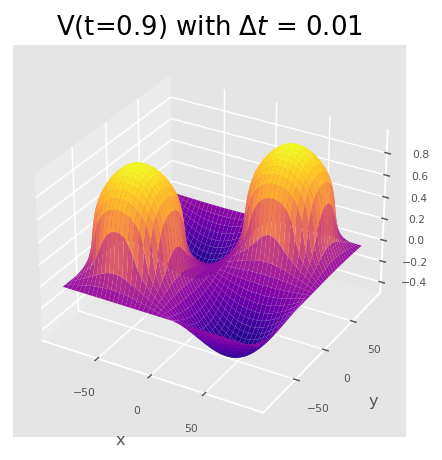

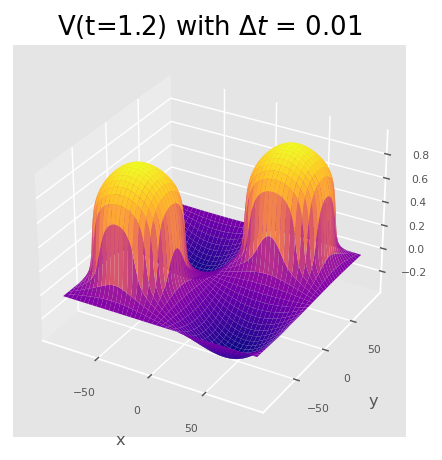

In [6]:
#constants
dt = .01
V_all = periodic(dt, Nx, Ny, 120, u0, v0)

#plot
skip = 30
for i, v in enumerate(V_all[::skip]):
    fig = plt.figure(dpi=130, facecolor='w')
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.set_title(f'V(t={round(skip*dt*i, 2)}) with $\Delta t$ = {round(dt, 2)}')
    ax.plot_surface(X, Y, v, cmap='plasma')
    plt.xlabel('x', size=9)
    plt.ylabel('y', size=9)
    plt.xticks(size=6)
    plt.yticks(size=6)
    ax.zaxis.set_tick_params(labelsize=6) 
    plt.show()

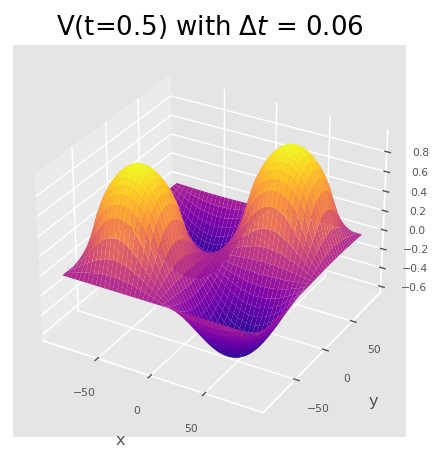

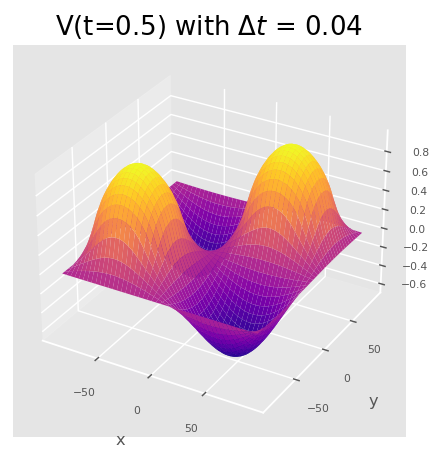

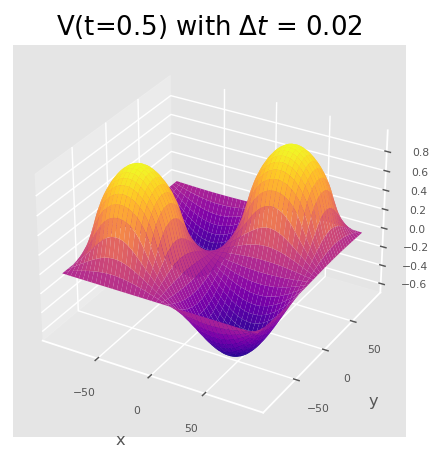

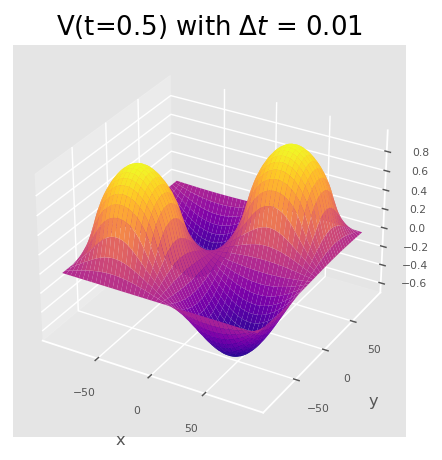

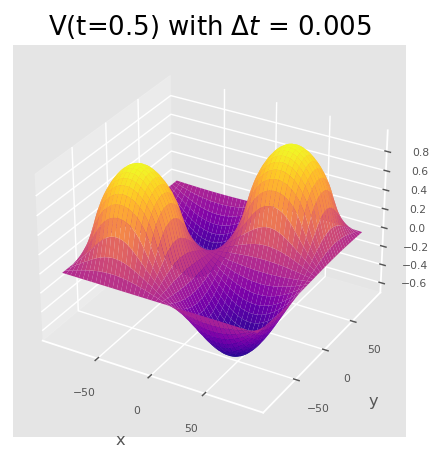

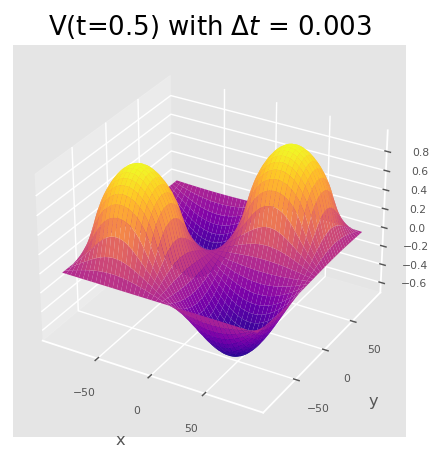

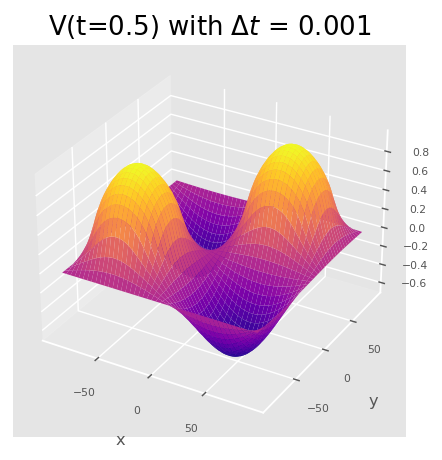

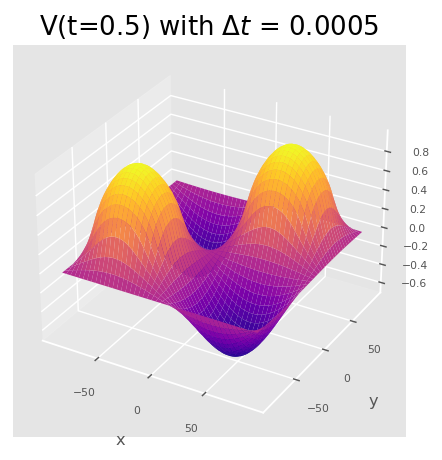

In [7]:
#constants
# dt_range = (.08, .04, .02, .01, .005, .0025, .00125, .0005125)
dt_range = (.06, .04, .02, .01, .005, .003, .001, .0005)
T = .5

#solve
V = [periodic(dt, Nx, Ny, int(T/dt), u0, v0)[-1] for dt in dt_range]

#plot
for v, dt in zip(V, dt_range):
    fig = plt.figure(dpi=130, facecolor='w')
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.set_title(f'V(t={T}) with $\Delta t$ = {round(dt, 5)}')
    ax.plot_surface(X, Y, v, cmap='plasma')
    plt.xlabel('x', size=9)
    plt.ylabel('y', size=9)
    plt.xticks(size=6)
    plt.yticks(size=6)
    ax.zaxis.set_tick_params(labelsize=6) 
    plt.show()

# Homework 34

In [8]:
def grid_norm(A, order=2):
    if order == np.inf:
        return np.max(A)
    else:
        n = A.size
        return np.power(np.sum(np.power(np.abs(A), order)), (1/order)) / n

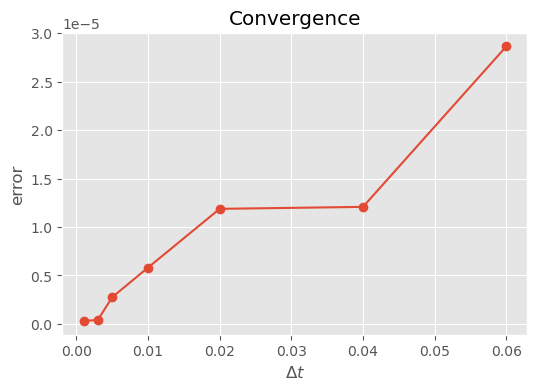

In [9]:
#get error
error = [grid_norm(v - V[-1]) for v in V[:-1]]
    
#plot
plt.figure(dpi=100)
plt.title('Convergence')
plt.plot(dt_range[:-1], error, '-o')
plt.xlabel('$\Delta t$')
plt.ylabel('error')
plt.show()

The solution blows up a little bit when $\Delta t$ is greater than about 0.06. But other than that, it seems to be converging pretty linearly.